In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, recall_score

from sklearn.linear_model import LinearRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
df = pd.read_csv('1.samsung_train.csv',encoding='CP949')

In [4]:
df.drop(['temp1','temp2','temp3','발생분변환'],axis=1,inplace=True)

In [5]:
# 총부상자수 변수

df['총부상자수']=df.사상자수 - df.사망자수
df.총부상자수.describe()

count    25037.000000
mean         0.580621
std          1.987263
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         96.000000
Name: 총부상자수, dtype: float64

In [6]:
# 충남 연기군 -> 세종 세종 변경 (12년 7월)
df.loc[df.발생지시군구=='연기군','발생지시군구']='세종'
df.loc[(df.발생지시도=='충남')&(df.발생지시군구=='세종'),'발생지시도']='세종'

In [8]:
# 충북 청원군 -> 충북 청주시 변경 (14년 7월)
df.loc[df.발생지시군구=='청원군','발생지시군구']='청주시'

In [9]:
# 대형교통사고 #

df_big=df[(df.사망자수>=3)|(df.사상자수>=20)]
df_big.head()

,발생년월일시,발생년,발생월,발생일,발생시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,사고유형,법규위반_대분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도,총부상자수
543,201705111520,2017,5,11,15,20,주간,목,5,14,1,8,0,강원,평창군,차대차,추돌,추돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승합차,승합차,승합차,승합차,1073759,1951258,128.329868,37.556878,9
748,201704230400,2017,4,23,4,0,야간,일,3,4,1,0,0,전남,여수시,차대차,측면충돌,측면충돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,화물차,화물차,1013558,1638000,127.648100,34.736452,1
799,201704161145,2017,4,16,11,45,주간,일,1,27,8,17,1,울산,남구,차대차,측면충돌,측면충돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승합차,승합차,승용차,승용차,1160678,1729618,129.272664,35.549539,26
804,201704160020,2017,4,16,0,20,야간,일,3,4,1,0,0,경기,화성시,차대사람,길가장자리구역통행중,길가장자리구역통행중,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,화물차,화물차,보행자,보행자,931961,1912794,126.733188,37.211486,1
993,201703251000,2017,3,25,10,0,주간,토,4,5,1,0,0,경북,상주시,차대차,정면충돌,정면충돌,운전자법규위반,중앙선 침범,단일로,기타단일로,화물차,화물차,화물차,화물차,1055350,1824390,128.117380,36.415436,1


# 1. test data 살펴보기

### - 변수별 분포 확인

In [10]:
df_test = pd.read_csv('test_kor.csv',encoding='CP949')

In [11]:
# 사망자수 #

train = [] 
train.append(df[df.사망자수 == 1].shape[0] / df.shape[0])
train.append(df[df.사망자수 == 2].shape[0] / df.shape[0])
train.append(df[df.사망자수 >= 3].shape[0] / df.shape[0])
train.append(0)

train = [round(i,3) for i in train]
#train

predict = []

predict.append(df_test.shape[0]*train[0])
predict.append(df_test.shape[0]*train[1])
predict.append(df_test.shape[0]*train[2])
predict.append(0)

predict = [round(i,0) for i in predict]
#predict

test = []

test.append((df_test.사망자수 == 1).sum())
test.append((df_test.사망자수 == 2).sum())
test.append(0)
test.append(df_test.사망자수.isnull().sum())
            
#test

temp = pd.DataFrame(index=['1','2','3','na'])

temp['train']=train
temp['predict']=predict
temp['test']=test
temp

,train,predict,test
1,0.967,48.0,34
2,0.028,1.0,7
3,0.005,0.0,0
na,0.000,0.0,9


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


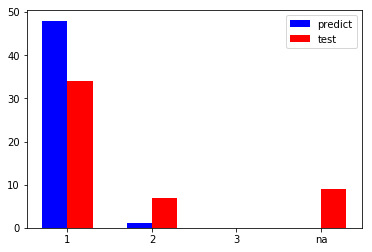

In [12]:
x = np.arange(4)

plt.bar(x-0.15, temp.predict,color='b',width=0.3 , label='predict')
plt.bar(x+0.15, temp.test   ,color='r',width=0.3 , label='test')

plt.legend()
plt.xticks(x,np.array(['1','2','3','na']));

사망자수 변수는 train data에서 보면 데이터의 96프로 정도가 1값, 3프로 정도가 2 값을 가지고, 3이상의 값을 갖는 데이터 수는 매우 적습니다. 

이때 만약 test data가 모 dataset에서 random sampling된 dataset이라면, test data의 사망자수의 분포는 train data와 비슷할 것입니다. 이에 train data에서의 분포로 test data에서 나타날 사망자 수를 예측해보면 1명인 데이터가 48개, 2명인 데이터가 1개, 3명 이상인 데이터는 많아봐야 1개 나타나야 합니다.

하지만 실제 test data에 나타난 사망자 수별 데이터수를 확인해보면, 사망자수가1명인 데이터는 34개, 2명인 데이터는 7개, 3명이상인 데이터는 아직 없고, 총 9개의 빈칸을 채워야 합니다.
이미 test data에서 사망자수가 2명인 데이터가 train data의 분포로 예상한 개수인 1개보다 7배나 많은 7개나 나왔기 때문에, train data와 test data의 사망자 수 분포는 조금 다르단 걸 알 수 있습니다.

이런 분포의 차이를 봤을 때, test data는 random sampling 돼지 않았고, 다른 stratified sampling이 사용됐을 가능성이 높다고 생각됩니다.
즉, 사망자수가 1명인 data들, 2명인 data들, 3명이상인 data들 각각의 집단에서 일정 숫자를 정해서 sampling 하기 때문에, 실제 train data에서 많이 나타나지 않는 outlier들도 test data에서는 충분히 나타날 가능성이 있습니다.

이에 특이하게 수치가 높게 나타나는 교통사고의 특징을 최대한 많이 잡아내서 그러한 교통사고를 잘 detect하는 작업이 중요하다고 생각합니다.

In [ ]:
# 사상자수 # 

In [13]:
df.사상자수.value_counts().sort_index()

# 1, 2, 3~4, 5~8, 9~15, 16~

1      18431
2       3537
3       1390
4        694
5        377
6        180
7        117
8         78
9         47
10        29
11        30
12        23
13        12
14        12
15         8
16         5
17         4
18        10
19         6
20         5
21         2
22         4
23         1
24         4
25         4
26         2
27         5
28         1
31         2
34         2
35         1
36         1
37         2
40         1
43         3
44         1
47         1
51         1
57         1
60         1
67         1
100        1
Name: 사상자수, dtype: int64

In [14]:
train = [] 

train.append(df[df.사상자수 == 1].shape[0] / df.shape[0])
train.append(df[df.사상자수 == 2].shape[0] / df.shape[0])
train.append(df[(df.사상자수 >= 3)&(df.사상자수<=4)].shape[0] / df.shape[0])
train.append(df[(df.사상자수 >= 5)&(df.사상자수<=8)].shape[0] / df.shape[0])
train.append(df[(df.사상자수 >= 9)&(df.사상자수<=15)].shape[0] / df.shape[0])
train.append(df[(df.사상자수 >= 16)].shape[0] / df.shape[0])
train.append(0)

train = [round(i,3) for i in train]
#train

predict = []

predict.append(df_test.shape[0]*train[0])
predict.append(df_test.shape[0]*train[1])
predict.append(df_test.shape[0]*train[2])
predict.append(df_test.shape[0]*train[3])
predict.append(df_test.shape[0]*train[4])
predict.append(df_test.shape[0]*train[5])
predict.append(0)

predict = [round(i,0) for i in predict]
#predict

test = []

test.append((df_test.사상자수 == 1).sum())
test.append((df_test.사상자수 == 2).sum())
test.append(((df_test.사상자수>=3) & (df_test.사상자수<=4)).sum())
test.append(((df_test.사상자수>=5) & (df_test.사상자수<=8)).sum())
test.append(((df_test.사상자수>=9) & (df_test.사상자수<=15)).sum())
test.append((df_test.사상자수>=16).sum())
test.append(df_test.사상자수.isnull().sum())
            
#test


temp = pd.DataFrame(index=['1','2','3~4','5~8','9~15','16~','na'])

temp['train']=train
temp['predict']=predict
temp['test']=test

temp

,train,predict,test
1,0.736,37.0,13
2,0.141,7.0,8
3~4,0.083,4.0,4
5~8,0.030,2.0,4
9~15,0.006,0.0,3
16~,0.003,0.0,1
na,0.000,0.0,17


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


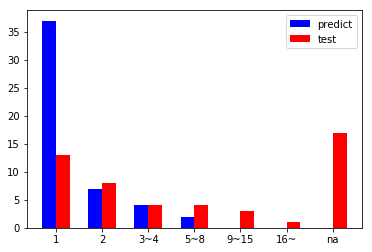

In [15]:
x = np.arange(7)

plt.bar(x-0.15, temp.predict,color='b',width=0.3, label='predict')
plt.bar(x+0.15, temp.test   ,color='r',width=0.3, label='test')

plt.legend()
plt.xticks(x,np.array(['1','2','3~4','5~8','9~15','16~','na']));

In [16]:
# 중상자수 #

df.중상자수.value_counts().sort_index()

# 0, 1, 2, 34, 5~8, 9~

0     20824
1      2698
2       837
3       338
4       142
5        68
6        44
7        27
8        17
9        10
10        5
11        5
12        3
13        5
14        1
15        2
16        2
17        1
18        1
21        1
22        1
25        1
26        1
28        1
45        1
54        1
Name: 중상자수, dtype: int64

In [17]:
train = [] 

train.append(df[df.중상자수 == 0].shape[0] / df.shape[0])
train.append(df[df.중상자수 == 1].shape[0] / df.shape[0])
train.append(df[df.중상자수 == 2].shape[0] / df.shape[0])
train.append(df[(df.중상자수 >= 3)&(df.중상자수<=4)].shape[0] / df.shape[0])
train.append(df[(df.중상자수 >= 5)&(df.중상자수<=8)].shape[0] / df.shape[0])
train.append(df[df.중상자수 >= 9].shape[0] / df.shape[0])
train.append(0)

train = [round(i,3) for i in train]
#train

predict = []

predict.append(df_test.shape[0]*train[0])
predict.append(df_test.shape[0]*train[1])
predict.append(df_test.shape[0]*train[2])
predict.append(df_test.shape[0]*train[3])
predict.append(df_test.shape[0]*train[4])
predict.append(df_test.shape[0]*train[5])
predict.append(0)

predict = [round(i,0) for i in predict]
#predict

test = []

test.append((df_test.중상자수 == 0).sum())
test.append((df_test.중상자수 == 1).sum())
test.append((df_test.중상자수 == 2).sum())
test.append(((df_test.중상자수>=3) & (df_test.중상자수<=4)).sum())
test.append(((df_test.중상자수>=5) & (df_test.중상자수<=8)).sum())
test.append((df_test.중상자수 >= 9).sum())
test.append(df_test.중상자수.isnull().sum())
            
#test

temp = pd.DataFrame(index=['0','1','2','3~4','5~8','9~','na'])

temp['train']=train
temp['predict']=predict
temp['test']=test

temp

,train,predict,test
0,0.832,42.0,23
1,0.108,5.0,7
2,0.033,2.0,1
3~4,0.019,1.0,4
5~8,0.006,0.0,0
9~,0.002,0.0,1
na,0.000,0.0,14


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


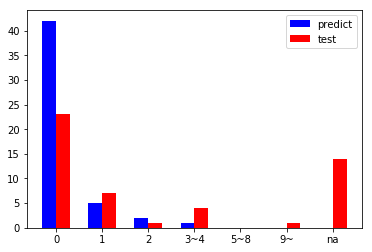

In [18]:
x = np.arange(7)

plt.bar(x-0.15, temp.predict,color='b',width=0.3, label='predict')
plt.bar(x+0.15, temp.test   ,color='r',width=0.3, label='test')

plt.legend()
plt.xticks(x,np.array(['0','1','2','3~4','5~8','9~','na']));

In [19]:
# 경상자수 #

df.경상자수.value_counts().sort_index()

#0, 1, 2, 34, 58, 9~

0     21818
1      2084
2       582
3       245
4       100
5        52
6        38
7        38
8        18
9        10
10        6
11        7
12        4
13        5
15        3
16        4
17        7
18        3
19        1
20        1
21        1
22        2
23        2
26        1
28        1
29        1
33        1
41        1
62        1
Name: 경상자수, dtype: int64

In [20]:
train = [] 

train.append(df[df.경상자수 == 0].shape[0] / df.shape[0])
train.append(df[df.경상자수 == 1].shape[0] / df.shape[0])
train.append(df[df.경상자수 == 2].shape[0] / df.shape[0])
train.append(df[(df.경상자수 >= 3)&(df.경상자수<=4)].shape[0] / df.shape[0])
train.append(df[(df.경상자수 >= 5)&(df.경상자수<=8)].shape[0] / df.shape[0])
train.append(df[df.경상자수 >= 9].shape[0] / df.shape[0])
train.append(0)

train = [round(i,3) for i in train]
#train

predict = []

predict.append(df_test.shape[0]*train[0])
predict.append(df_test.shape[0]*train[1])
predict.append(df_test.shape[0]*train[2])
predict.append(df_test.shape[0]*train[3])
predict.append(df_test.shape[0]*train[4])
predict.append(df_test.shape[0]*train[5])
predict.append(0)

predict = [round(i,0) for i in predict]
#predict

test = []

test.append((df_test.경상자수 == 0).sum())
test.append((df_test.경상자수 == 1).sum())
test.append((df_test.경상자수 == 2).sum())
test.append(((df_test.경상자수>=3) & (df_test.경상자수<=4)).sum())
test.append(((df_test.경상자수>=5) & (df_test.경상자수<=8)).sum())
test.append((df_test.경상자수 >= 9).sum())
test.append(df_test.경상자수.isnull().sum())
            
#test

temp = pd.DataFrame(index=['0','1','2','3~4','5~8','9~','na'])

temp['train']=train
temp['predict']=predict
temp['test']=test

temp

,train,predict,test
0,0.871,44.0,27
1,0.083,4.0,5
2,0.023,1.0,3
3~4,0.014,1.0,1
5~8,0.006,0.0,2
9~,0.002,0.0,4
na,0.000,0.0,8


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


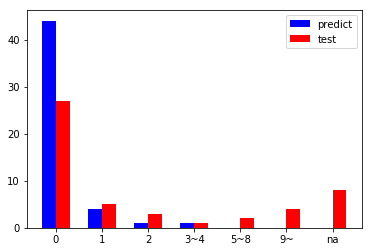

In [21]:
x = np.arange(7)

plt.bar(x-0.15, temp.predict,color='b',width=0.3, label='predict')
plt.bar(x+0.15, temp.test   ,color='r',width=0.3, label='test')

plt.legend()
plt.xticks(x,np.array(['0','1','2','3~4','5~8','9~','na']));

In [22]:
# 부상신고자수 # 

df.부상신고자수.value_counts()

# 0, 1, 23, 4~

0     24596
1       353
2        43
3        17
4         7
6         6
5         5
7         4
30        1
14        1
11        1
9         1
67        1
16        1
Name: 부상신고자수, dtype: int64

In [23]:
train = [] 

train.append(df[df.부상신고자수 == 0].shape[0] / df.shape[0])
train.append(df[df.부상신고자수 == 1].shape[0] / df.shape[0])
train.append(df[(df.부상신고자수 >= 2)&(df.부상신고자수<=3)].shape[0] / df.shape[0])
train.append(df[df.부상신고자수 >= 4].shape[0] / df.shape[0])
train.append(0)

train = [round(i,3) for i in train]
# train

predict = []

predict.append(df_test.shape[0]*train[0])
predict.append(df_test.shape[0]*train[1])
predict.append(df_test.shape[0]*train[2])
predict.append(df_test.shape[0]*train[3])
predict.append(0)

predict = [round(i,0) for i in predict]
# predict

test = []

test.append((df_test.부상신고자수 == 0).sum())
test.append((df_test.부상신고자수 == 1).sum())
test.append(((df_test.부상신고자수>=2) & (df_test.부상신고자수<=3)).sum())
test.append((df_test.부상신고자수 >= 4).sum())
test.append(df_test.부상신고자수.isnull().sum())
            
# test

temp = pd.DataFrame(index=['0','1','2~3','4~','na'])

temp['train']=train
temp['predict']=predict
temp['test']=test

temp

,train,predict,test
0,0.982,49.0,45
1,0.014,1.0,1
2~3,0.002,0.0,0
4~,0.001,0.0,2
na,0.000,0.0,2


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


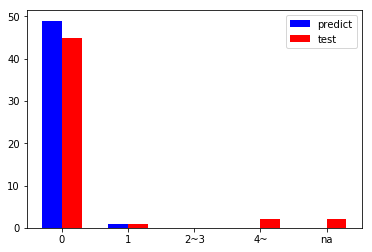

In [24]:
x = np.arange(5)

plt.bar(x-0.15, temp.predict,color='b',width=0.3, label='predict')
plt.bar(x+0.15, temp.test   ,color='r',width=0.3, label='test')

plt.legend()
plt.xticks(x,np.array(['0','1','2~3','4~','na']));

In [ ]:
# 발생지역 # 

In [25]:
def get_dist(df, df_test, variable):
    train = (df[variable].value_counts() / df.shape[0])
    train.append(pd.Series([0]))

    ind = train.index.tolist()
    ind.append('na')

    temp = pd.DataFrame(index=ind)

    temp['train'] = round(train,2)
    temp['predict'] = round(train * 50,0)


    test = []
    for i in df[variable].value_counts().index.tolist():
    
        test.append((df_test[variable] == i).sum())

    test.append((df_test[variable].isnull()).sum())

    temp['test'] = test
    
    

    x = np.arange(temp.shape[0])

    plt.figure(figsize=(12,6))
    plt.bar(x-0.15, temp.predict,color='b',width=0.3, label='predict')
    plt.bar(x+0.15, temp.test   ,color='r',width=0.3, label='test')

    plt.legend()
    plt.xticks(x,temp.index);
    
    return temp

In [41]:
# get_dist(df, df_test, '발생지시도')

In [42]:
# 사고유형 대분류 # 

# get_dist(df, df_test, '사고유형_대분류')

In [43]:
# 사고유형 중분류 #

# get_dist(df,df_test,'사고유형_중분류')

In [44]:
# 법규위반 #

# get_dist(df,df_test,'법규위반')

In [45]:
# 도로형태 #

# get_dist(df, df_test,'도로형태')

In [46]:
# 요일 #

# get_dist(df,df_test,'요일')

In [47]:
# 주야 #

# get_dist(df,df_test,'주야')

test data에서 각 변수별 분포를 살펴보니, 

# 2. 사고 위험도

경기도지역 통계자료에 보면, 교통사고 위험도라는 지표가 존재.     
             
각 지역별로 다음을 계산.         
(사망자수*12 + 부상자수*3)/교통사고건수            
       
사망자수에 가중치를 더 주고 교통사고 건수로 나눴기때문에, 각 지역별로 교통사고가 발생했을 때 인명피해가 어느정도 나는지를 비교할 수 있을 것이라고 생각.     
         
그런데 다른 지역에서는 이 지표에 관한 자료를 찾기 힘들어서, 구하는 식을 조금 변형해서 train data에 사용해보기로 함.    
원래 지표의 분모에는 교통사고건수가 들어가는데, train data에서는 전체 교통사고 건수가 아닌 교통사망사고 건수를 구할 수 있으니, 분모를 교통사망사고건수로 넣고 계산해보기로 함.     
            
이때 단순 지역별 사고 위험도만 계산하지 말고 train data에서 주어진 여러 변수들의 조합과 관련된 사고 위험도들을 계산하여, 사고 위험도가 높은 여러 조건들을 만들고자 함.
예를들어, 요일x주야 별로 사고위험도1을 측정, 당사자종별 조합별로 사고위험도2를 측정한 결과, 토요일 낮에 발생하는 사고들이 사고위험도1이 높고, 승합차-승합차 조합에서 사고위험도2가 높게 나타났다고 하자. 그러면 어떤 교통사고가 토요일 낮에 승합차 승합차끼리 발생했으면, 사고위험도 합이 매우 높으니 대형 교통사고일 확률이 조금 높지 않을까 생각.     

그런데 사고 피해자들 수치를 이용해서 위험도라는 변수를 새로 만드니까, 이 변수를 이용해서 다시 피해자들 수치를 예측하면 답을 알고 수치를 예측하는 것과 같아서 train set안에서 overfitting 될 가능성이 높다고 생각한다. 이에 애초에 train set을 train_train, train_test set으로 나눈 후, train_train set 데이터만 이용해서 이 위험도를 측정한 후, 이를 train_test set에도 적용시켜서 위험도가 높은 사고일수록 실제 피해가 크게 나타나는지를 확인해보고자 함.  

In [27]:
df_test.columns

Index(['주야', '요일', '사망자수', '사상자수', '중상자수', '경상자수', '부상신고자수', '발생지시도', '발생지시군구',
       '사고유형_대분류', '사고유형_중분류', '법규위반', '도로형태_대분류', '도로형태', '당사자종별_1당_대분류',
       '당사자종별_2당_대분류'],
      dtype='object')

In [28]:
X = df[['주야', '요일','사망자수', '사상자수', '중상자수', '경상자수', '부상신고자수','총부상자수', '발생지시도', '발생지시군구', '사고유형_대분류', '사고유형_중분류', '법규위반', '도로형태_대분류', '도로형태', '당사자종별_1당_대분류',
       '당사자종별_2당_대분류']]

y = df[['사망자수', '사상자수', '중상자수', '경상자수', '부상신고자수']]

In [32]:
train_train, train_test, y_train, y_test = train_test_split(X,y,test_size=0.4, random_state=42)

In [33]:
train_train.shape, y_train.shape, train_test.shape, y_test.shape

((15022, 17), (15022, 5), (10015, 17), (10015, 5))

## - 발생시군구_위험도

In [37]:
df_big.groupby(['발생지시도','발생지시군구']).count().발생년.sort_values(ascending=False).head()

발생지시도  발생지시군구
경기     화성시       5
인천     서구        5
전남     여수시       5
충남     천안시       4
충북     충주시       4
Name: 발생년, dtype: int64

대형교통사고는 애초에 잘 발생하지 않아서 아예 발생하지 않은 지역도 있는데, 반대로 특히 몇몇 지역에서는 4~5번씩 자주 발생했음.    
교통사고가 발생하면 대형교통사고로 이어지기 쉬운 특정 지역이 있을 것이라고 생각.        
이때 시도 단위는 너무 넓어서 그런 특정 일부 지역의 특성을 반영하지는 못한다고 생각해서 군구 단위로 위험도를 계산해보기로 함. 

In [38]:
# 지역별 전체 교통사고 횟수

total= train_train.groupby(['발생지시도','발생지시군구']).count().주야.sort_index()
#total

# 지역별 사망자 수

a = train_train.groupby(['발생지시도','발생지시군구']).sum().사망자수.sort_index()
#a

# 지역별 총 부상자수

b = train_train.groupby(['발생지시도','발생지시군구']).sum().총부상자수.sort_index()
#b

temp = (a*12 + b*3)/total

for i,j in temp.index:
    train_train.loc[(train_train.발생지시도==i)&(train_train.발생지시군구==j),'발생시군구_위험도'] = temp[i,j]

train_train.발생시군구_위험도.describe()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    15022.000000
mean        14.273865
std          1.070885
min         12.000000
25%         13.688702
50%         14.178082
75%         14.742188
max         26.666667
Name: 발생시군구_위험도, dtype: float64

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


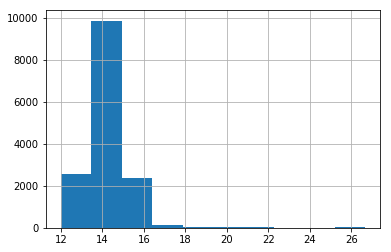

In [39]:
train_train.발생시군구_위험도.hist();

In [40]:
train_train[train_train.발생시군구_위험도>=16].groupby('발생지시군구').mean().발생시군구_위험도.sort_values(ascending=False)

발생지시군구
고성군     26.666667
곡성군     20.806452
평창군     20.341463
단양군     19.200000
임실군     17.333333
중구      17.225806
부평구     16.615385
인제군     16.500000
해운대구    16.260000
보령시     16.237500
장수군     16.050000
Name: 발생시군구_위험도, dtype: float64

In [41]:
temp = train_train.groupby(['발생지시도','발생지시군구']).mean().발생시군구_위험도

for i, j in temp.index:
    train_test.loc[(train_test.발생지시도==i)&(train_test.발생지시군구==j),'발생시군구_위험도'] = temp[i,j]    

train_test.발생시군구_위험도.describe()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    10015.000000
mean        14.273218
std          1.015729
min         12.000000
25%         13.692308
50%         14.210526
75%         14.742857
max         26.666667
Name: 발생시군구_위험도, dtype: float64

In [45]:
train_test.loc[X_test.사망자수>=3].groupby('발생지시군구').mean().발생시군구_위험도.sort_values(ascending=False).head()

발생지시군구
평창군     20.341463
임실군     17.333333
해운대구    16.260000
강릉시     15.720000
정선군     15.681818
Name: 발생시군구_위험도, dtype: float64

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


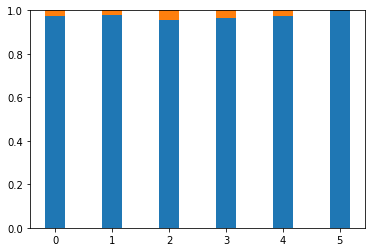

In [76]:
high=[]
low=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.발생시군구_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.발생시군구_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.발생시군구_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.발생시군구_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.발생시군구_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.발생시군구_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.발생시군구_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.발생시군구_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.발생시군구_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.발생시군구_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=20)].shape[0]
a = train_test[(train_test.사상자수>=20)&(train_test.발생시군구_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=20)&(train_test.발생시군구_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

N = 6 
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, low, width)
p2 = plt.bar(ind, high, width, bottom=low)

#plt.ylabel('주야 비율')
#plt.xticks(ind, ('전체','일반적인 사고','특이한 사고','사망자 높/ 부상자 낮','사망자 낮/ 부상자 높','사망자 높 / 부상자 높'))
#plt.legend((p1[0],p2[0]),('주간','야간'))
plt.show()

## - 발생지시도x요일x(주야) 위험도

In [77]:
df['요일x주야'] = df['요일'] + '/' + df['주야']
#df['요일x주야'] = df['요일x주야'].apply(lambda x : '/'.join(sorted(x.split('/'))))

In [78]:
temp = pd.DataFrame(df.groupby('요일x주야').mean().사상자수)
temp = temp.loc[['월/주간','월/야간','화/주간','화/야간','수/주간','수/야간','목/주간','목/야간','금/주간','금/야간','토/주간','토/야간','일/주간','일/야간']]
temp

,사상자수
요일x주야,
월/주간,1.612423
월/야간,1.487254
화/주간,1.681167
화/야간,1.481784
수/주간,1.659977
수/야간,1.567232
목/주간,1.682149
목/야간,1.466220
금/주간,1.780542


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


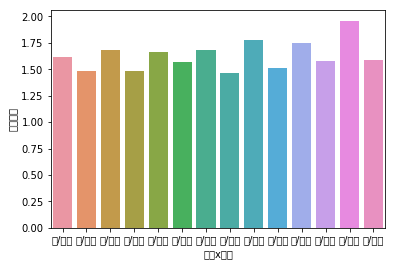

In [79]:
sns.barplot(x=temp.index, y=temp.사상자수)

보통 주간에 야간에비해 평균사상자수가 높게 나타난다. 또한 미세하긴 하지만 평일보다는 금토일 주간에 수치가 높게 나타난다.      
이는 주로 야간보다 주간에, 또 평일보다는 주말에 많이 활동하는 우리의 생활패턴이 반영된 결과라고 생각.     
       
요일과 주야와 더불어서 우리의 생활 패턴에 또 많은 영향을 주는 것은 어느 시도인지. 대도시인지 대도시 주변 지역인지에 따라서 요일,주야별로 사람들의 이동 패턴이 다르게 나타날 것임. 즉 차량의 흐름이 시도x요일x주야 별로 다르니, 평균 사상자수도 다른 패턴을 보일 것임.    
      
시도x요일x주야별로 평균 사상자수 살펴보기

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


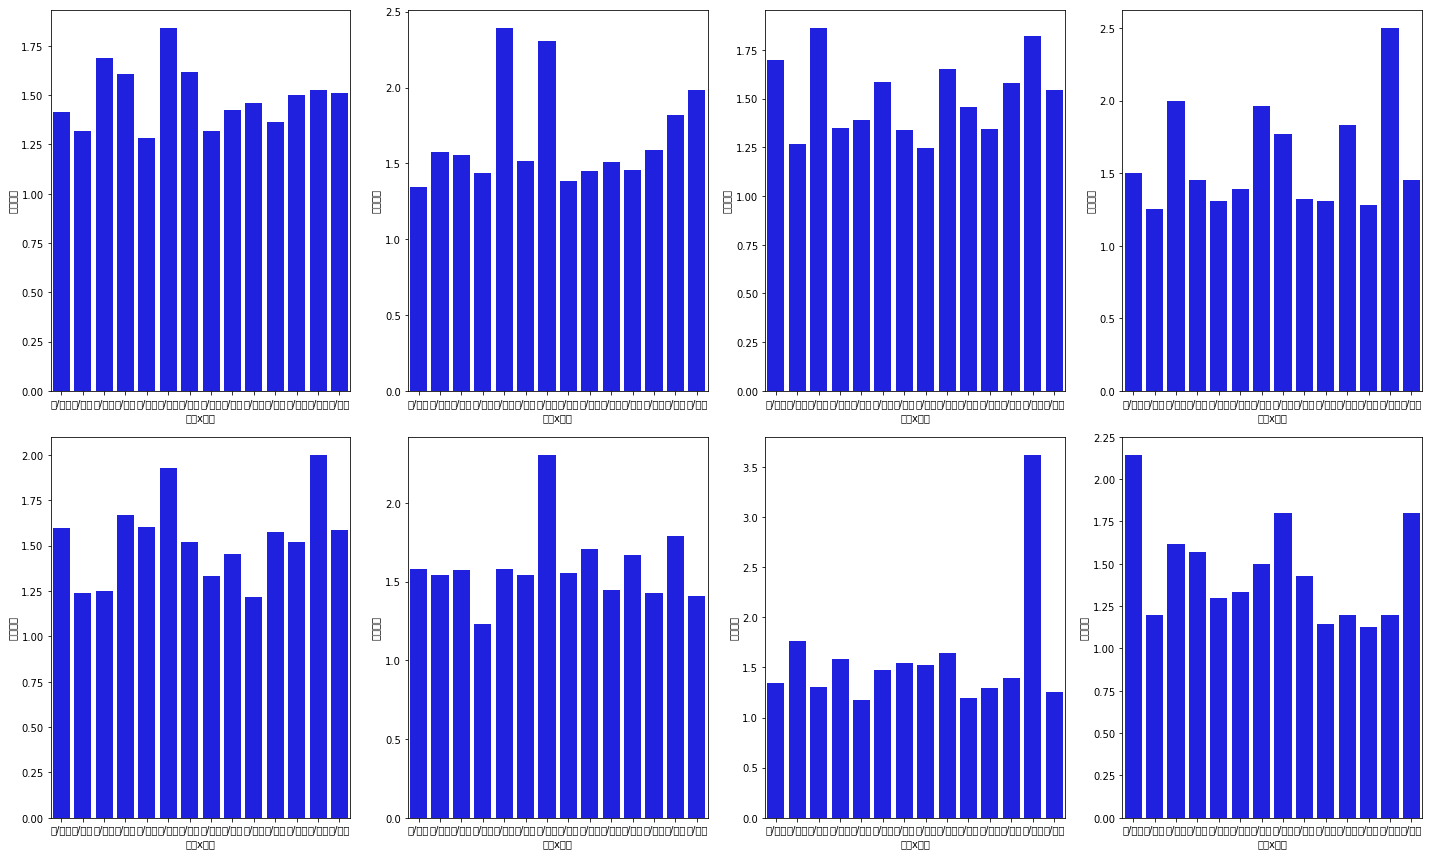

In [80]:
a = ['서울','인천','부산','울산','대구','광주','대전','세종']


fig = plt.figure(figsize=(20,12))

for n,i in enumerate(a):
    temp = pd.DataFrame(df[df.발생지시도==i].groupby('요일x주야').mean().사상자수)
    temp = temp.loc[['월/주간','월/야간','화/주간','화/야간','수/주간','수/야간','목/주간','목/야간','금/주간','금/야간','토/주간','토/야간','일/주간','일/야간']]
    
    
    
    ax = fig.add_subplot(2,4,n+1)
    sns.barplot(x=temp.index, y=temp.사상자수,ax=ax, color='b')
    
plt.tight_layout()


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


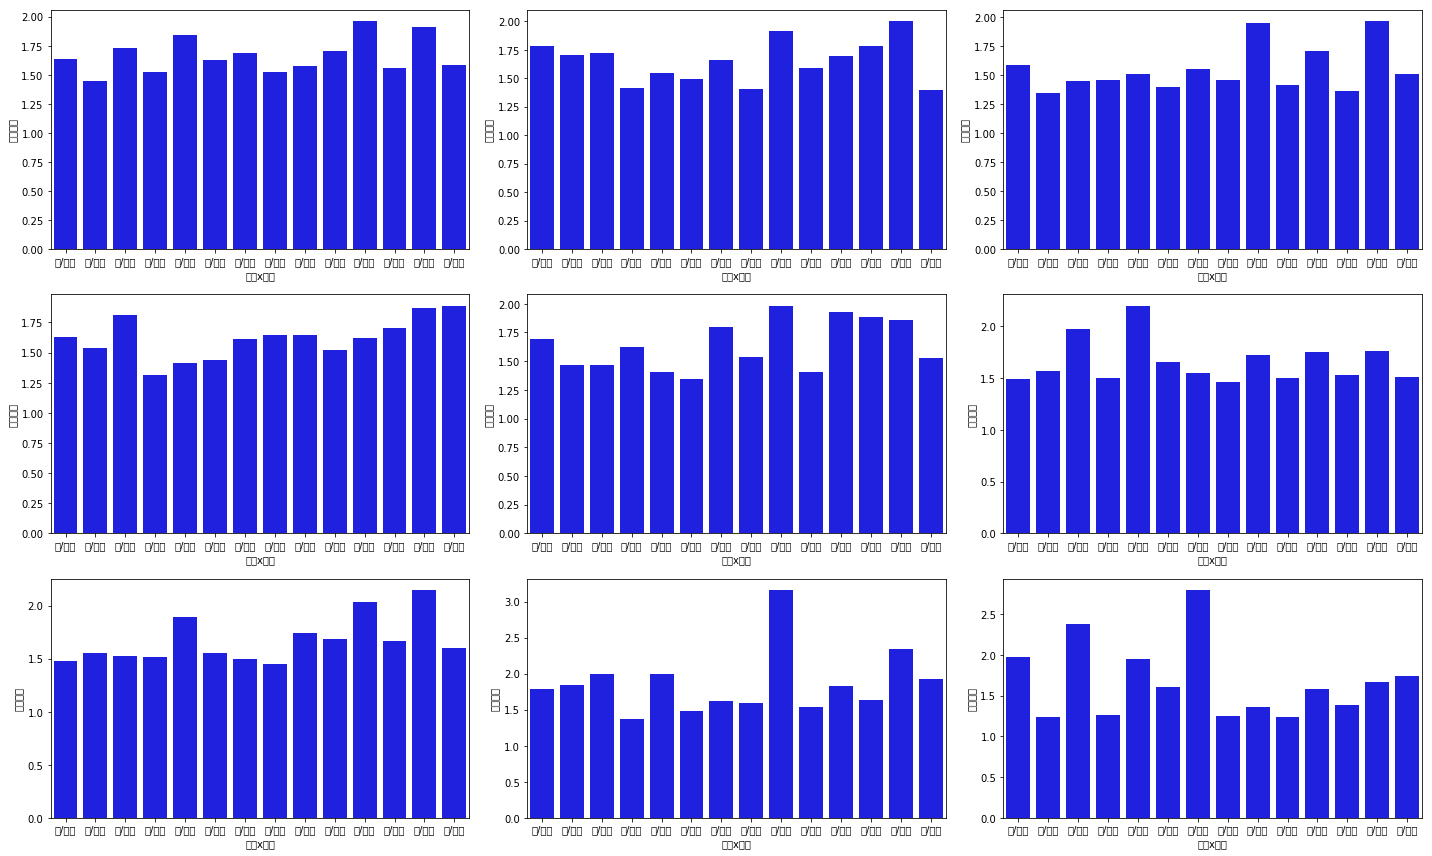

In [351]:
b=  ['경기','경북','경남','전북','전남','충북','충남','강원','제주']


fig = plt.figure(figsize=(20,12))

for n,i in enumerate(b):
    temp = pd.DataFrame(df[df.발생지시도==i].groupby('요일x주야').mean().사상자수)
    temp = temp.loc[['월/주간','월/야간','화/주간','화/야간','수/주간','수/야간','목/주간','목/야간','금/주간','금/야간','토/주간','토/야간','일/주간','일/야간']]
    
    
    
    ax = fig.add_subplot(3,3,n+1)
    sns.barplot(x=temp.index, y=temp.사상자수,ax=ax, color='b')
    
plt.tight_layout()


차량들의 이동 패턴이 시도x요일x주야별로 다르게 나타나니, 사고 위험도도 시도x요일x주야를 기준으로 계산하기.

In [82]:
train_train.columns

Index(['주야', '요일', '사망자수', '사상자수', '중상자수', '경상자수', '부상신고자수', '총부상자수', '발생지시도',
       '발생지시군구', '사고유형_대분류', '사고유형_중분류', '법규위반', '도로형태_대분류', '도로형태',
       '당사자종별_1당_대분류', '당사자종별_2당_대분류', '발생시군구_위험도'],
      dtype='object')

In [83]:
total = train_train.groupby(['발생지시도','요일','주야']).count().도로형태.sort_index()
#total

a = train_train.groupby(['발생지시도','요일','주야']).sum().사망자수.sort_index()
#a

b=train_train.groupby(['발생지시도','요일','주야']).sum().총부상자수.sort_index()
#b

temp = (a*12+b*3)/total

#temp

for i,j,k in temp.index:
    train_train.loc[(train_train.발생지시도==i)&(train_train.요일==j)&(train_train.주야==k),'발생지시도x요일x주야_위험도'] = temp[i,j,k]

train_train.발생지시도x요일x주야_위험도.describe()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    15022.000000
mean        14.273865
std          1.048010
min         12.000000
25%         13.626168
50%         14.096234
75%         14.680000
max         21.420000
Name: 발생지시도x요일x주야_위험도, dtype: float64

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


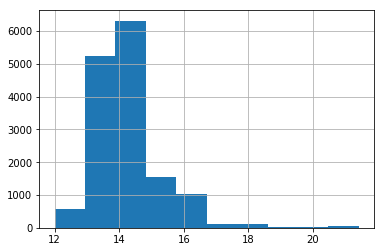

In [84]:
train_train.발생지시도x요일x주야_위험도.hist()

In [87]:
train_train[train_train.발생지시도x요일x주야_위험도>=16].groupby(['발생지시도','요일','주야']).mean().발생지시도x요일x주야_위험도.sort_values(ascending=False).head()

발생지시도  요일  주야
강원     금   주간    21.420000
제주     화   주간    19.650000
광주     목   주간    19.411765
제주     목   주간    18.545455
울산     일   주간    18.400000
Name: 발생지시도x요일x주야_위험도, dtype: float64

In [89]:
temp = train_train.groupby(['발생지시도','요일','주야']).mean().발생지시도x요일x주야_위험도
for i, j, k in temp.index:
    train_test.loc[(train_test.발생지시도==i)&(train_test.요일==j)&(train_test.주야==k),'발생지시도x요일x주야_위험도'] = temp[i,j,k]    

train_test.발생지시도x요일x주야_위험도.describe()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    10015.000000
mean        14.271924
std          1.062931
min         12.000000
25%         13.645161
50%         14.096234
75%         14.650000
max         21.420000
Name: 발생지시도x요일x주야_위험도, dtype: float64

In [91]:
train_test.loc[X_test.사망자수>=3].groupby(['발생지시도','요일','주야']).mean().발생지시도x요일x주야_위험도.sort_values(ascending=False).head()

발생지시도  요일  주야
광주     목   주간    19.411765
강원     일   주간    18.000000
충북     화   주간    16.500000
강원     월   야간    15.937500
전북     화   주간    15.821053
Name: 발생지시도x요일x주야_위험도, dtype: float64

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


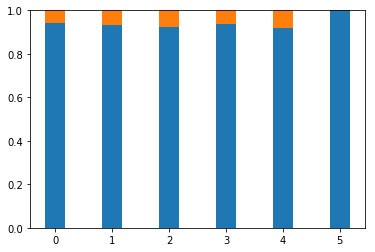

In [118]:
high=[]
low=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.발생지시도x요일x주야_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.발생지시도x요일x주야_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.발생지시도x요일x주야_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.발생지시도x요일x주야_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.발생지시도x요일x주야_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.발생지시도x요일x주야_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.발생지시도x요일x주야_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.발생지시도x요일x주야_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.발생지시도x요일x주야_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.발생지시도x요일x주야_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=20)].shape[0]
a = train_test[(train_test.사상자수>=20)&(train_test.발생지시도x요일x주야_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=20)&(train_test.발생지시도x요일x주야_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

N = 6 
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, low, width)
p2 = plt.bar(ind, high, width, bottom=low)

#plt.ylabel('주야 비율')
#plt.xticks(ind, ('전체','일반적인 사고','특이한 사고','사망자 높/ 부상자 낮','사망자 낮/ 부상자 높','사망자 높 / 부상자 높'))
#plt.legend((p1[0],p2[0]),('주간','야간'))
plt.show()

## - 차량x사고유형중분류_위험도

우선 특히 사고가 나면 피해자가 많이 생기는 차종 조합이 있을 것 같다.

In [95]:
df['차량조합'] = df['당사자종별_1당_대분류'] + '/' + df['당사자종별_2당_대분류']

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


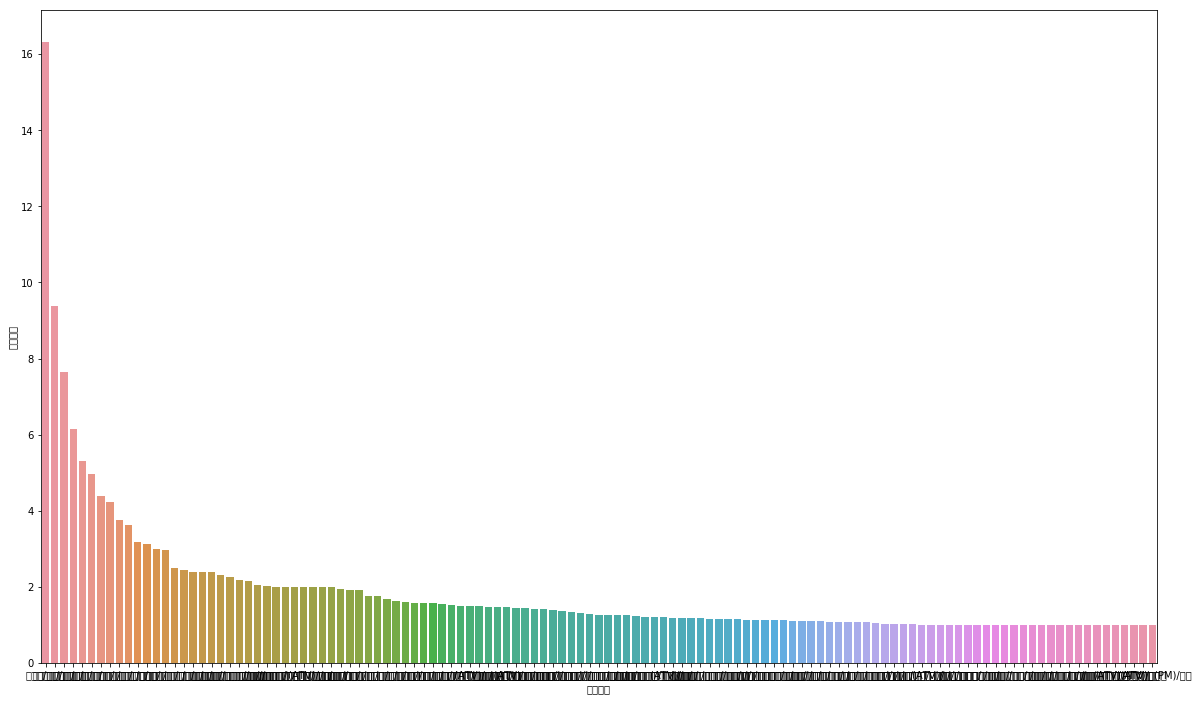

In [96]:
temp = pd.DataFrame(df.groupby('차량조합').mean().사상자수.sort_values(ascending=False))

plt.figure(figsize=(20,12))
sns.barplot(x=temp.index, y=temp.사상자수);

차종 조합별로 평균 사상자수가 비슷비슷한 경우도 있지만, 일부 차종에서는 유난히 수치가 높게 나타남.       
즉, 사고가 나면 위험한 특정 몇몇 차종 조합이 있다고 생각.

이때 혹시 차종조합에 따라서 덜 위험한 사고유형이나 더 위험한 사고 유형이 있는지 몇몇 차량조합 확인해보기.

In [97]:
temp.head()

,사상자수
차량조합,
승합차/승합차,16.333333
건설기계/승합차,9.375000
승합차/건설기계,7.642857
승합차/화물차,6.144444
승합차/승용차,5.301370


In [98]:
print(df[df.차량조합=='승합차/승합차'].groupby('사고유형_중분류').mean().사상자수.sort_index(ascending=False))
print('----------------------')
print(df[df.차량조합=='승합차/승합차'].groupby('사고유형_중분류').count().사상자수.sort_index(ascending=False))

사고유형_중분류
측면직각충돌    12.300000
추돌        21.950000
정면충돌       6.833333
기타        13.833333
Name: 사상자수, dtype: float64
----------------------
사고유형_중분류
측면직각충돌    10
추돌        20
정면충돌       6
기타         6
Name: 사상자수, dtype: int64


In [99]:
print(df[df.차량조합=='건설기계/승합차'].groupby('사고유형_중분류').mean().사상자수.sort_index(ascending=False))
print('----------------------')
print(df[df.차량조합=='건설기계/승합차'].groupby('사고유형_중분류').count().사상자수.sort_index(ascending=False))

사고유형_중분류
측면충돌       1.000000
측면직각충돌    10.333333
추돌        12.000000
Name: 사상자수, dtype: float64
----------------------
사고유형_중분류
측면충돌      1
측면직각충돌    6
추돌        1
Name: 사상자수, dtype: int64


In [100]:
print(df[df.차량조합=='승합차/건설기계'].groupby('사고유형_중분류').mean().사상자수.sort_index(ascending=False))
print('----------------------')
print(df[df.차량조합=='승합차/건설기계'].groupby('사고유형_중분류').count().사상자수.sort_index(ascending=False))

사고유형_중분류
측면직각충돌     9.5
추돌         2.6
정면충돌      14.4
기타         1.5
Name: 사상자수, dtype: float64
----------------------
사고유형_중분류
측면직각충돌    2
추돌        5
정면충돌      5
기타        2
Name: 사상자수, dtype: int64


차량 조합별로 더 위험한 사고유형 중분류가 있을 수도 있겠지만, 너무 잘게 쪼개다보니 각 경우별로 데이터 수가 너무 적어지는 문제가 있어서, 그냥 차종조합별로 위험도를 계산해야 할 듯.

In [101]:
total = train_train.groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).count().사고유형_중분류
#total

a = train_train.groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).sum().사망자수.sort_index()
#a

b = train_train.groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).sum().총부상자수.sort_index()
#b

temp = (a*12+b*3)/total

temp

for i,j in temp.index:
    train_train.loc[(train_train.당사자종별_1당_대분류==i)&(train_train.당사자종별_2당_대분류==j),'차량조합_위험도'] = temp[i,j]

train_train.차량조합_위험도.describe()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    15022.000000
mean        14.273865
std          3.866146
min         12.000000
25%         12.451557
50%         12.548387
75%         14.298335
max         69.782609
Name: 차량조합_위험도, dtype: float64

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


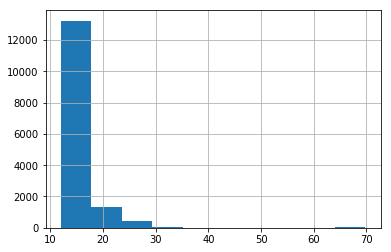

In [102]:
train_train.차량조합_위험도.hist()

In [103]:
train_train[train_train.차량조합_위험도>=20].groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).mean().차량조합_위험도.sort_values(ascending=False)

당사자종별_1당_대분류  당사자종별_2당_대분류
승합차           승합차             69.782609
건설기계          승합차             64.000000
승합차           건설기계            46.800000
              화물차             31.187500
              승용차             27.230769
승용차           열차              27.000000
화물차           승합차             25.836735
승용차           승합차             24.327869
특수차           특수차             24.000000
건설기계          승용차             24.000000
특수차           승용차             22.666667
승합차           없음              22.077670
원동기장치자전거      이륜차             21.000000
건설기계          특수차             21.000000
Name: 차량조합_위험도, dtype: float64

In [104]:
temp = train_train.groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).mean().차량조합_위험도
for i, j in temp.index:
    train_test.loc[(train_test.당사자종별_1당_대분류==i)&(train_test.당사자종별_2당_대분류==j),'차량조합_위험도'] = temp[i,j]    
train_test.차량조합_위험도.describe()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    10006.000000
mean        14.268425
std          4.141830
min         12.000000
25%         12.451557
50%         12.548387
75%         14.298335
max         69.782609
Name: 차량조합_위험도, dtype: float64

In [105]:
train_test.loc[train_test.사상자수>=10].groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).mean().차량조합_위험도.sort_values(ascending=False).head()

당사자종별_1당_대분류  당사자종별_2당_대분류
승합차           승합차             69.782609
건설기계          승합차             64.000000
승합차           건설기계            46.800000
              화물차             31.187500
              승용차             27.230769
Name: 차량조합_위험도, dtype: float64

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


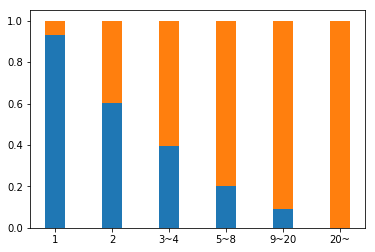

In [117]:
high=[]
low=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.차량조합_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.차량조합_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.차량조합_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.차량조합_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.차량조합_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.차량조합_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.차량조합_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.차량조합_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.차량조합_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.차량조합_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=20)].shape[0]
a = train_test[(train_test.사상자수>=20)&(train_test.차량조합_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=20)&(train_test.차량조합_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

N = 6 
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, low, width)
p2 = plt.bar(ind, high, width, bottom=low)

#plt.ylabel('주야 비율')
plt.xticks(ind, ('1','2','3~4','5~8','9~20','20~'))
#plt.legend((p1[0],p2[0]),('주간','야간'))
plt.show()

## - 사고유형중분류_위험도

In [108]:
df[df.사고유형_대분류=='차대차'].사고유형_중분류.value_counts()

측면직각충돌    3037
추돌        2668
기타        2260
정면충돌      1589
측면충돌       298
후진중충돌        5
Name: 사고유형_중분류, dtype: int64

In [109]:
df.groupby('사고유형_중분류').mean().사상자수.sort_values(ascending=False)

사고유형_중분류
직전진행          3.000000
정면충돌          2.640025
추돌            2.488006
차단기돌파         2.000000
측면직각충돌        1.983866
측면충돌          1.795302
주/정차차량 충돌     1.600000
공작물충돌         1.520690
기타            1.487429
전도            1.424528
전도전복          1.417363
도로이탈          1.416048
전복            1.333333
보도통행중         1.295620
후진중충돌         1.200000
길가장자리구역통행중    1.178344
횡단중           1.091098
차도통행중         1.076835
경보기무시         1.000000
Name: 사상자수, dtype: float64

사고유형 중분류에서 차대사람 사고인 횡단중, 차도통행중, 보도통행중, 길가장자리구역 통행중사고는 피해 규모가 크지 않아 위험도가 작아 보인다. 
반면 차대차 사고는 그 안에서도 후진중충돌의 경우 평균 사상자수가 1.2명이고, 정면충돌은 2.64이다. 즉 피해의 심각성의 분산이 크기때문에,    
사고유형 대분류보다 더 세세하게 중분류별로 위험도를 파악해야할 것 같다.

In [110]:
total = train_train.groupby(['사고유형_중분류']).count().당사자종별_1당_대분류
#total

a = train_train.groupby(['사고유형_중분류']).sum().사망자수.sort_index()
#a

b = train_train.groupby(['사고유형_중분류']).sum().총부상자수.sort_index()
#b

temp = (a*12+b*3)/total

temp

for i in temp.index:
    train_train.loc[(train_train.사고유형_중분류==i),'사고유형_위험도'] = temp[i]

train_train.사고유형_위험도.describe()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    15022.000000
mean        14.273865
std          1.795045
min         12.000000
25%         12.340360
50%         13.770619
75%         15.392697
max         27.000000
Name: 사고유형_위험도, dtype: float64

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


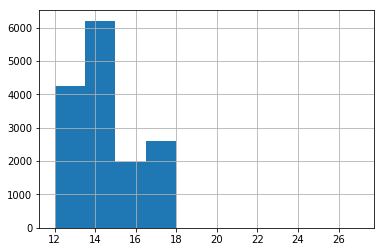

In [111]:
train_train.사고유형_위험도.hist()

In [112]:
train_train[train_train.사고유형_위험도>=16].groupby(['사고유형_중분류']).mean().사고유형_위험도.sort_values(ascending=False)

사고유형_중분류
직전진행     27.000000
차단기돌파    19.500000
정면충돌     17.849693
추돌       17.502783
Name: 사고유형_위험도, dtype: float64

In [113]:
temp = train_train.groupby(['사고유형_중분류']).mean().사고유형_위험도
for i in temp.index:
    train_test.loc[(train_test.사고유형_중분류==i),'사고유형_위험도'] = temp[i]    
train_test.사고유형_위험도.describe()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    10015.000000
mean        14.265647
std          1.764440
min         12.000000
25%         12.832258
50%         13.770619
75%         15.392697
max         17.849693
Name: 사고유형_위험도, dtype: float64

In [114]:
train_test.loc[train_test.사망자수>=3].groupby(['사고유형_중분류']).mean().사고유형_위험도.sort_values(ascending=False)

사고유형_중분류
정면충돌         17.849693
추돌           17.502783
측면직각충돌       15.392697
측면충돌         15.033149
공작물충돌        14.056082
기타           13.770619
전도전복         13.627010
도로이탈         13.591687
주/정차차량 충돌    12.000000
Name: 사고유형_위험도, dtype: float64

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


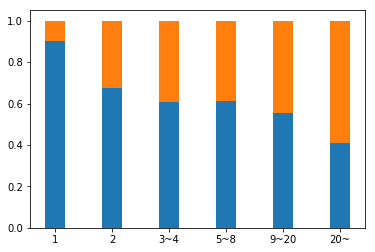

In [116]:
high=[]
low=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.사고유형_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.사고유형_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.사고유형_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.사고유형_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.사고유형_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.사고유형_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.사고유형_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.사고유형_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.사고유형_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.사고유형_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=20)].shape[0]
a = train_test[(train_test.사상자수>=20)&(train_test.사고유형_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=20)&(train_test.사고유형_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

N = 6 
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, low, width)
p2 = plt.bar(ind, high, width, bottom=low)

#plt.ylabel('주야 비율')
plt.xticks(ind, ('1','2','3~4','5~8','9~20','20~'))
#plt.legend((p1[0],p2[0]),('주간','야간'))
plt.show()

## - 4가지 위험도

In [119]:
train_test['위험도합']=train_test.발생시군구_위험도 + train_test.발생지시도x요일x주야_위험도 + train_test.차량조합_위험도 + train_test.사고유형_위험도
train_test['위험도평균']=train_test.위험도합 / 4

train_test[['위험도합','위험도평균']].head()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,위험도합,위험도평균
22192,53.819662,13.454915
20239,52.982943,13.245736
20989,58.036769,14.509192
18177,54.773560,13.693390
14464,54.200541,13.550135


In [120]:
print(train_test.위험도합.describe())
print('-------')
print(train_test.위험도평균.describe())

count    10006.000000
mean        57.077518
std          5.408939
min         49.690955
25%         53.718797
50%         55.624031
75%         58.970989
max        117.443093
Name: 위험도합, dtype: float64
-------
count    10006.000000
mean        14.269379
std          1.352235
min         12.422739
25%         13.429699
50%         13.906008
75%         14.742747
max         29.360773
Name: 위험도평균, dtype: float64


위험도합은 60이상이면 조금 위험하다고 볼 수 있고, 위험도평균은 16정도 이상이면 위험하다고 생각

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


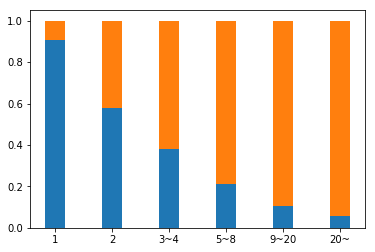

In [121]:
high=[]
low=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.위험도합<=60)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.위험도합>60)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.위험도합<=60)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.위험도합>60)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.위험도합<=60)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.위험도합>60)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.위험도합<=60)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.위험도합>60)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.위험도합<=60)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.위험도합>60)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=20)].shape[0]
a = train_test[(train_test.사상자수>=20)&(train_test.위험도합<=60)].shape[0]
b = train_test[(train_test.사상자수>=20)&(train_test.위험도합>60)].shape[0]

low.append(a/total)
high.append(b/total)

N = 6 
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, low, width)
p2 = plt.bar(ind, high, width, bottom=low)

#plt.ylabel('주야 비율')
plt.xticks(ind, ('1','2','3~4','5~8','9~20','20~'))
#plt.legend((p1[0],p2[0]),('주간','야간'))
plt.show()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


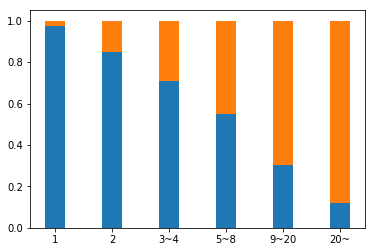

In [122]:
high=[]
low=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.위험도평균<=16)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.위험도평균>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.위험도평균<=16)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.위험도평균>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.위험도평균<=16)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.위험도평균>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.위험도평균<=16)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.위험도평균>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.위험도평균<=16)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.위험도평균>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=20)].shape[0]
a = train_test[(train_test.사상자수>=20)&(train_test.위험도평균<=16)].shape[0]
b = train_test[(train_test.사상자수>=20)&(train_test.위험도평균>16)].shape[0]

low.append(a/total)
high.append(b/total)

N = 6 
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, low, width)
p2 = plt.bar(ind, high, width, bottom=low)

#plt.ylabel('주야 비율')
plt.xticks(ind, ('1','2','3~4','5~8','9~20','20~'))
#plt.legend((p1[0],p2[0]),('주간','야간'))
plt.show()

In [ ]:
train_test.발생시군구_위험도
train_test.발생지시도x요일x주야_위험도

train data를 기준으로 계산한 4가지 위험도들을 test data에 그대로 사용해본 결과, 발생지시군구_위험도와 발생지시도x요일x주야_위험도보다는 차량조합_위험도와 사고유형_위험도가 좀 더 피해자가 큰 사고를 예측하는데 유용할 것 같다.      
       
4가지를 모두 합한 위험도합이나 평균을 낸 위험도 평균수치도 사상자수가 많은 사고일수록 위험도 수치가 높게 측정된 사고의 비율이 많아, 피해자 수가 많은 특이한 사고를 예측하는데 조금이나마 도움이 되지 않을까.             
나중에 사용할때는 train_train, train_test set을 합한 전체 train data에서 4가지 위험도를 계산한 후 test data에 변수를 추가하여 사용하면 될 것 같다.

# 3. 추가데이터

## - 사고안전지수

In [124]:
df_safe = pd.read_csv('safe.csv',encoding='CP949')

In [125]:
df_safe.head()

,시,군구,2012,2013,2014,2015,2016,평균
0,서울,종로구,67.3,66.4,68.4,71.3,76.9,70.1
1,서울,중구,58.9,58.5,65.2,61.0,68.5,62.4
2,서울,용산구,76.3,76.6,79.0,76.3,79.1,77.5
3,서울,성동구,83.5,83.0,81.0,85.8,80.4,82.7
4,서울,동대문구,73.9,73.2,66.6,76.7,74.3,72.9


In [127]:
temp = df_safe.groupby(['시','군구']).mean().평균
temp.head()

시   군구 
강원  강릉시    83.6
    고성군    76.2
    동해시    81.9
    삼척시    80.1
    속초시    78.8
Name: 평균, dtype: float64

In [128]:
for i,j in temp.index:
    df.loc[(df.발생지시도==i)&(df.발생지시군구==j),'사고안전도']=temp[i,j]
    
df.head()

# 인천 옹진군, 울릉군은 안전도가 계산이 안돼있음. 그래서 비슷한 정도로 사고가 나는 지역의 사고안전도를 사용
# 인천 옹진군 = 충북 증평군
# 경북 울릉군 = 경기 과천시

,발생년월일시,발생년,발생월,발생일,발생시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,사고유형,법규위반_대분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도,총부상자수,요일x주야,차량조합,사고안전도
0,201706302314,2017,6,30,23,14,야간,금,1,1,0,0,0,경기,성남시,차대사람,횡단중,횡단중,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,보행자,보행자,967633,1937456,127.134130,37.435704,0,금/야간,승용차/보행자,76.4
1,201706302145,2017,6,30,21,45,야간,금,1,4,2,1,0,전남,곡성군,차대차,추돌,추돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,승용차,승용차,966456,1696405,127.131220,35.262534,3,금/야간,승용차/승용차,76.7
2,201706302150,2017,6,30,21,50,야간,금,1,1,0,0,0,충남,서산시,차대사람,차도통행중,차도통행중,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,보행자,보행자,900057,1865697,126.379922,36.784142,0,금/야간,승용차/보행자,73.5
3,201706301910,2017,6,30,19,10,야간,금,1,1,0,0,0,대구,서구,차대차,측면충돌,측면충돌,운전자법규위반,안전운전 의무 불이행,교차로,교차로부근,승용차,승용차,이륜차,이륜차,1095230,1764891,128.554945,35.875973,0,금/야간,승용차/이륜차,72.0
4,201706301702,2017,6,30,17,2,주간,금,1,2,1,0,0,서울,영등포구,차대차,측면충돌,측면충돌,운전자법규위반,중앙선 침범,단일로,교량위,이륜차,이륜차,화물차,화물차,947576,1946355,126.906786,37.514993,1,금/주간,이륜차/화물차,72.8


In [129]:
df.사고안전도.isnull().sum()

0

In [130]:
df[df.사고안전도<=65]

,발생년월일시,발생년,발생월,발생일,발생시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,사고유형,법규위반_대분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도,총부상자수,요일x주야,차량조합,사고안전도
60,201706261115,2017,6,26,11,15,주간,월,1,4,1,2,0,서울,중구,차대차,기타,기타,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승합차,승합차,자전거,자전거,956705,1950843,127.009818,37.555919,3,월/주간,승합차/자전거,62.4
99,201706212155,2017,6,21,21,55,야간,수,1,1,0,0,0,서울,중구,차대차,추돌,추돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,이륜차,이륜차,화물차,화물차,957011,1951843,127.013224,37.564946,0,수/야간,이륜차/화물차,62.4
151,201706160920,2017,6,16,9,20,주간,금,1,3,2,0,0,전남,영암군,차대차,추돌,추돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,화물차,화물차,승합차,승합차,898309,1638614,126.389408,34.736047,2,금/주간,화물차/승합차,63.2
178,201706141537,2017,6,14,15,37,주간,수,1,3,2,0,0,경북,군위군,차대차,정면충돌,정면충돌,운전자법규위반,중앙선 침범,단일로,기타단일로,화물차,화물차,화물차,화물차,954112,1950024,128.592603,36.148164,2,수/주간,화물차/화물차,62.7
193,201706130515,2017,6,13,5,15,야간,화,1,1,0,0,0,경북,군위군,차대사람,횡단중,횡단중,운전자법규위반,중앙선 침범,단일로,기타단일로,화물차,화물차,보행자,보행자,1101588,1799252,128.629780,36.185069,0,화/야간,화물차/보행자,62.7
242,201706072018,2017,6,7,20,18,야간,수,1,1,0,0,0,전남,영암군,차대사람,횡단중,횡단중,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,화물차,화물차,보행자,보행자,926941,1644841,126.701678,34.795406,0,수/야간,화물차/보행자,63.2
268,201706041500,2017,6,4,15,0,주간,일,1,1,0,0,0,경북,군위군,차대사람,횡단중,횡단중,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,보행자,보행자,1098102,1804374,128.591659,36.231598,0,일/주간,승용차/보행자,62.7
285,201706031715,2017,6,3,17,15,주간,토,1,1,0,0,0,경북,경주시,차대사람,횡단중,횡단중,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,화물차,화물차,보행자,보행자,1160960,1780958,129.286096,36.012164,0,토/주간,화물차/보행자,61.7
340,201705282125,2017,5,28,21,25,야간,일,1,2,1,0,0,경북,군위군,차대차,정면충돌,정면충돌,운전자법규위반,신호위반,교차로,교차로내,승용차,승용차,승합차,승합차,1096784,1791647,128.574554,36.112798,1,일/야간,승용차/승합차,62.7
364,201705262120,2017,5,26,21,20,야간,금,1,1,0,0,0,전남,영암군,차량단독,전도전복,전도전복,운전자법규위반,안전운전 의무 불이행,주차장,주차장,원동기장치자전거,원동기장치자전거,없음,없음,927000,1646055,126.701898,34.806453,0,금/야간,원동기장치자전거/없음,63.2


# - 날씨 위험도

특히 큰 사고가 날 위험이 높은 날씨가 있을까. 날씨별로 사고위험도 측정

In [131]:
df_sun = pd.read_csv('safe_sun.csv',encoding='CP949')
df_sun

,분류,12,13,14,15,16,평균
0,합계,4.91,4.86,4.78,4.77,4.74,4.81
1,기타,4.78,4.61,4.31,4.46,4.49,4.53
2,맑음,4.85,4.82,4.74,4.73,4.70,4.77
3,비,5.17,5.09,5.07,4.95,4.91,5.04
4,흐림,5.23,5.12,5.04,5.04,5.12,5.11
5,눈,5.54,5.87,5.29,5.54,5.68,5.58
6,안개,6.46,6.74,6.10,7.39,7.17,6.77


In [132]:
df_sun['차이']=df_sun.평균-4.81
df_sun

,분류,12,13,14,15,16,평균,차이
0,합계,4.91,4.86,4.78,4.77,4.74,4.81,0.00
1,기타,4.78,4.61,4.31,4.46,4.49,4.53,-0.28
2,맑음,4.85,4.82,4.74,4.73,4.70,4.77,-0.04
3,비,5.17,5.09,5.07,4.95,4.91,5.04,0.23
4,흐림,5.23,5.12,5.04,5.04,5.12,5.11,0.30
5,눈,5.54,5.87,5.29,5.54,5.68,5.58,0.77
6,안개,6.46,6.74,6.10,7.39,7.17,6.77,1.96


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


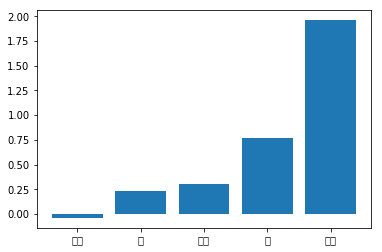

In [133]:
ind = np.arange(df_sun.shape[0]-2)

plt.bar(ind, df_sun.차이[2:])
plt.xticks(ind, np.array(df_sun.분류[2:]));

# 시군구별 평균 강우량, 강설량, 안개일수 추가?
# 세부적인 시군구별 평균 안개일수나 날씨 수치들을 구하기 힘들다. 보통 다 시별로 나와있음.
# 다른 날씨 특성들과 달리, 안개의 경우 안개사고다발지역이 존재. 이에  7-11년 사이 안개로 인한 교통사고 4건 이상 발생지역들의 사고발생건수를 사용해보기.

전체 사고위험도와의 차이를 보면, 안개낀날과 눈내리는 날에 특히 사고위험도가 높게 나타난다.        
그래서 시군구별로 평균 강우량, 강설량, 안개일수를 추가하려고 했으나, 기상청 데이터가 시도 단위로만 데이터를 제공하는 것 같아서 구하지 못했음.                           
                           
다른 날씨 특성들과 달리, 안개의 경우에는 안개사고다발지역이라는 지표가 존재함. 즉 다른 날씨들에 비해 특히 안개가 교통사고에 큰 영향을 미친다고 생각. 이에 7~11년 사이에 안개로 이한 교통사고가 4건이상 발생한 지역들의 사고발생건수 변수로 사용해보기

In [136]:
df_fogregion=pd.read_csv('fog_region.csv',encoding='CP949')
df_fogregion.groupby(['시','군구']).mean().발생건수.sort_values(ascending=False).head()

시   군구  
충북  진천군     13
충남  예산군     12
제주  서귀포시     9
세종  세종       9
경기  포천시      8
Name: 발생건수, dtype: int64

충북 진천군이나 충남 예산군같이 특히 안개로 이한 교통사고가 많은 지역이 있음.

In [137]:
temp = df_fogregion.groupby(['시','군구']).mean().발생건수

for i,j in temp.index:
    df.loc[(df.발생지시도==i)&(df.발생지시군구==j),'안개사고건수']=temp[i,j]
    
df.안개사고건수.isnull().sum()

0

In [138]:
a = []
a.append(df.사상자수.mean())
a.append(df.사망자수.mean())
a.append(df.중상자수.mean())
a.append(df.경상자수.mean())
a.append(df.부상신고자수.mean())

b=[]
b.append(df[df.안개사고건수==0].사상자수.mean())
b.append(df[df.안개사고건수==0].사망자수.mean())
b.append(df[df.안개사고건수==0].중상자수.mean())
b.append(df[df.안개사고건수==0].경상자수.mean())
b.append(df[df.안개사고건수==0].부상신고자수.mean())

c=[]
c.append(df[df.안개사고건수!=0].사상자수.mean())
c.append(df[df.안개사고건수!=0].사망자수.mean())
c.append(df[df.안개사고건수!=0].중상자수.mean())
c.append(df[df.안개사고건수!=0].경상자수.mean())
c.append(df[df.안개사고건수!=0].부상신고자수.mean())

temp = pd.DataFrame(index=['사상자수','사망자수','중상자수','경상자수','부상신고자수'])
temp['전체']=a
temp['no']=b
temp['yes']=c

temp

,전체,no,yes
사상자수,1.621520,1.619027,1.633410
사망자수,1.040899,1.041455,1.038249
중상자수,0.299996,0.297241,0.313134
경상자수,0.250509,0.248973,0.257834
부상신고자수,0.030115,0.031357,0.024194


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


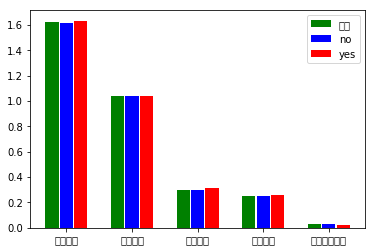

In [139]:
x = np.arange(temp.shape[0])

plt.bar(x-0.22, temp.전체   ,color='g',width=0.2, label='전체')
plt.bar(x     , temp.no     ,color='b',width=0.2, label='no')
plt.bar(x+0.22, temp.yes    ,color='r',width=0.2, label='yes')

plt.legend()
plt.xticks(x,np.array(temp.index));

# 안개사고다발지역인지 아닌지는 부상자수에 영향을 미치지는 않는 것 같다. 우리나라에서는 워낙 잘 안일어나는 현상이라 그런것 같다.

우리나라에서 안개끼는 날이 그렇게 많지 않다보니, 안개가 많이 끼는 지역이더라도 피해자수 규모가 특히 높거나 하진 않음. 이 변수는 안쓰는게 좋을 것 같다

# - 시군구 위험도

In [325]:
df_시군구위험도=pd.read_csv('safe_si.csv',encoding='CP949')
df_시군구위험도

,시,군구,2013,2014,2015,2016,2017,평균
0,전국,합계,4.86,4.78,4.77,4.74,4.71,4.77
1,서울,합계,4.43,4.34,4.33,4.28,4.29,4.33
2,서울,종로구,4.29,4.19,4.17,4.12,4.39,4.23
3,서울,중구,4.19,4.17,4.11,4.16,4.07,4.14
4,서울,용산구,4.48,4.45,4.32,4.45,4.48,4.44
5,서울,성동구,4.06,4.43,4.30,4.37,4.35,4.30
6,서울,동대문구,3.94,4.08,4.02,3.93,3.91,3.98
7,서울,성북구,4.27,4.14,4.22,4.00,4.12,4.15
8,서울,도봉구,4.15,4.12,4.22,4.27,4.05,4.16
9,서울,은평구,4.15,4.38,4.33,4.21,4.32,4.28


In [338]:
# 시도별 전국평균과의 차이 

temp = df_시군구위험도.loc[df_시군구위험도.군구=='합계',['시','평균']]
temp['차이']=df_시군구위험도.평균-4.77
temp.loc[temp.차이.sort_values().index]

,시,평균,차이
1,서울,4.33,-0.44
27,부산,4.35,-0.42
44,대구,4.45,-0.32
76,울산,4.63,-0.14
53,인천,4.68,-0.09
70,대전,4.70,-0.07
225,경남,4.75,-0.02
0,전국,4.77,0.00
244,제주,4.79,0.02
84,경기,4.83,0.06


In [339]:
temp = temp[1:]

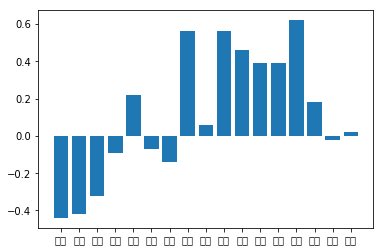

In [341]:
ind = np.arange(temp.shape[0])

plt.bar(ind,temp.차이)
plt.xticks(ind, np.array(temp.시));

# 전국평균위험도보다 특히 높은 시들이 있음. 
# 전남, 세종, 강원, 충북, 전북, 충남, 광주, 경북, 경기, 제주

In [344]:
df[(df.사망자수>=3)|(df.사상자수>=20)].발생지시도.value_counts()

경기    30
경남    19
전남    18
경북    17
충남    13
전북    12
강원    11
충북    10
인천     7
제주     5
서울     5
대구     4
광주     4
부산     4
울산     3
대전     1
Name: 발생지시도, dtype: int64

In [264]:
for i in temp.시.unique():
    df.loc[df.발생지시도==i,'시_위험도'] = temp.loc[temp.시==i,'차이']

df.시_위험도.isnull().sum()

25036

In [269]:
for i in temp.시.unique():
    print(i)

서울
부산
대구
인천
광주
대전
울산
세종
경기
강원
충북
충남
전북
전남
경북
경남
제주


In [268]:
df[-df.시_위험도.isnull()]

,발생년월일시,발생년,발생월,발생일,발생시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,사고유형,법규위반_대분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도,사고안전도,시_위험도
84,201706230656,2017,6,23,6,56,주간,금,1,1,0,0,0,경기,안양시,차대차,측면충돌,측면충돌,운전자법규위반,안전운전 의무 불이행,교차로,교차로부근,승용차,승용차,원동기장치자전거,원동기장치자전거,951810,1931162,126.955687,37.378285,77.4,0.06


In [257]:
df.loc[df.발생지시도=='서울','발생년']

4        2017
21       2017
26       2017
27       2017
30       2017
41       2017
60       2017
77       2017
86       2017
91       2017
99       2017
102      2017
103      2017
110      2017
114      2017
133      2017
134      2017
140      2017
142      2017
147      2017
157      2017
167      2017
201      2017
232      2017
257      2017
271      2017
281      2017
300      2017
302      2017
318      2017
338      2017
343      2017
360      2017
363      2017
385      2017
393      2017
403      2017
411      2017
422      2017
459      2017
469      2017
496      2017
503      2017
507      2017
508      2017
510      2017
513      2017
523      2017
591      2017
596      2017
603      2017
609      2017
626      2017
628      2017
647      2017
666      2017
679      2017
681      2017
688      2017
703      2017
722      2017
723      2017
727      2017
745      2017
760      2017
764      2017
769      2017
780      2017
828      2017
849      2017
873      2017
883   

In [263]:
temp.loc[temp.시=='서울','차이']

1   -0.44
Name: 차이, dtype: float64

In [ ]:
df.발생지시도

In [ ]:
# 군구별 전국평균과의 차이 


In [245]:
# 군구별 전국평균과의 차이 

temp = df_시군구위험도.loc[df_시군구위험도.시=='서울',['군구','평균']]
temp['차이']=temp.평균-4.33
temp=temp[1:]
temp.loc[temp.차이.sort_values().index]

,군구,평균,차이
6,동대문구,3.98,-0.35
22,중랑구,4.11,-0.22
3,중구,4.14,-0.19
7,성북구,4.15,-0.18
25,강북구,4.16,-0.17
8,도봉구,4.16,-0.17
16,관악구,4.18,-0.15
2,종로구,4.23,-0.10
21,양천구,4.25,-0.08
9,은평구,4.28,-0.05


# - 도로유형별 위험도

대형교통사고들은 주로 차량평균속도가 높은 고속도로나 큰 도로에서 발생하지 않을까 생각. 그래서 도로별 사고위험도를 계산해봄.

In [141]:
df_도로=pd.read_csv('safe_road.csv',encoding='CP949')
df_도로

,도로유형,2012,2013,2014,2015,2016,평균
0,합계,4.91,4.86,4.78,4.77,4.74,4.81
1,기타,4.00,3.97,3.87,3.85,3.80,3.90
2,특별광역시도,4.60,4.59,4.53,4.50,4.47,4.64
3,시도,4.82,4.81,4.78,4.73,4.74,4.78
4,지방도,5.34,5.29,5.12,5.18,5.12,5.21
5,일반국도,6.19,6.22,6.00,5.94,5.70,6.01
6,고속국도,8.30,8.25,8.10,7.99,7.87,8.10


In [142]:
df_도로['차이']=df_도로.평균-4.81
temp = df_도로[['도로유형','차이']]
temp = temp[2:]
temp

,도로유형,차이
2,특별광역시도,-0.17
3,시도,-0.03
4,지방도,0.40
5,일반국도,1.20
6,고속국도,3.29


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['"C:/Windows/Fonts/NanumBarunGothic.ttf"'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


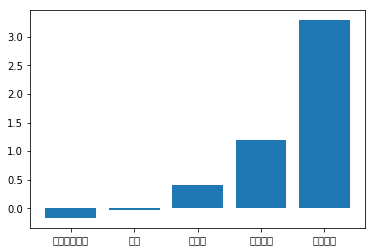

In [143]:
ind = np.arange(temp.shape[0])

plt.bar(ind,temp.차이)
plt.xticks(ind, np.array(temp.도로유형));

# 보통 고속도로와 일반국도에서 사고가 났을 때, 건당 피해수치가 높은 것 같다.
# 지역별 고속국도, 일반국도

보면 고속도로의 사고위험도가 유난히 높게 나타남. 규모가 큰 교통사고는 주로 고속도로에서 발생할까?                   
현재 데이터에는 사고가 어느 도로에서 발생하는지 구체적으로 보여주지 않아서 직접 몇몇 사고들을 찾아봄. 찾아보니 주로 고속도로에서 발생하거나, 그 지역 주요 도로에서 발생하는 것 같음. 이에 시군구별 도로 데이터를 찾아서 어떻게 활용할 지 생각해보기.